In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [1]:
!pip install kaggle

In [3]:
!kaggle datasets download -d danushkumarv/indian-monuments-image-dataset

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!mv /content/kaggle.json /root/.kaggle

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!unzip /content/indian-monuments-image-dataset.zip -d /content

**2-load the dataset and split it into train and test**

In [4]:
folder = "Indian-monuments"

In [5]:
import os
from PIL import Image

# Function to resize images in a directory and its subdirectories
def resize_images(directory, target_size=(150, 150)):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)

            try:
                # Open the image
                image = Image.open(file_path)

                # Resize the image
                resized_image = image.resize(target_size)

                # Save the resized image, overwriting the original
                resized_image.save(file_path)

                print(f"Resized {file_path} to {target_size}")

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Replace 'your_unzipped_folder' with the path to the unzipped folder
unzipped_folder_path = folder

# Resize images in the specified folder and its subdirectories
resize_images(unzipped_folder_path)


Resized Indian-monuments\images\test\Ajanta Caves\1.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\10.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\11.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\12.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\13.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\14.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\15.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\16.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\17.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\18.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\19.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\2.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\20.jpg to (150, 150)
Resized Indian-monuments\images\test\Ajanta Caves\21.jpg to (150, 150)
Resized 

In [6]:
datagen = ImageDataGenerator(rescale=1/255)

NameError: name 'ImageDataGenerator' is not defined

In [3]:
batch_size = 32
image_size = (150, 150)  # Adjust the size as needed

data_dir='Indian-monuments/images/train'
train=keras.utils.image_dataset_from_directory(data_dir,image_size=image_size,
                                                label_mode='categorical',
                                                seed=123)
data_dir='Indian-monuments/images/test'
val=keras.utils.image_dataset_from_directory(data_dir,image_size=image_size,
                                             label_mode = 'categorical',
                                              seed=123)



Found 3666 files belonging to 24 classes.
Found 990 files belonging to 24 classes.


In [4]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Ajanta Caves',
 1: 'Charar-E- Sharif',
 2: 'Chhota_Imambara',
 3: 'Ellora Caves',
 4: 'Fatehpur Sikri',
 5: 'Gateway of India',
 6: 'Humayun_s Tomb',
 7: 'India gate pics',
 8: 'Khajuraho',
 9: 'Sun Temple Konark',
 10: 'alai_darwaza',
 11: 'alai_minar',
 12: 'basilica_of_bom_jesus',
 13: 'charminar',
 14: 'golden temple',
 15: 'hawa mahal pics',
 16: 'iron_pillar',
 17: 'jamali_kamali_tomb',
 18: 'lotus_temple',
 19: 'mysore_palace',
 20: 'qutub_minar',
 21: 'tajmahal',
 22: 'tanjavur temple',
 23: 'victoria memorial'}

In [5]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32, 24)


In [12]:
for i in range(4):
    for j in range(8):
        index = i * 8 + j
        image = batch[0][index].astype(int)

        # Convert label to a hashable type (assuming it's a NumPy array)
        label = tuple(batch[1][index])

        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(label_to_class_name.get(label, str(label)))  # Use get() to handle missing labels

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

NameError: name 'batch' is not defined

In [6]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

**3-load vgg19 architecture and build the model**

In [41]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(24, activation='softmax'))
pretrained_model.trainable=False

In [42]:
VGG_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
epochs=15
history = VGG_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
115/115 [==============================] - 12s 94ms/step - loss: 1.6855 - accuracy: 0.5436 - val_loss: 2.6032 - val_accuracy: 0.4147
Epoch 2/15
115/115 [==============================] - 10s 90ms/step - loss: 0.7801 - accuracy: 0.7842 - val_loss: 3.0676 - val_accuracy: 0.4604
Epoch 3/15
115/115 [==============================] - 11s 95ms/step - loss: 0.5528 - accuracy: 0.8532 - val_loss: 3.7221 - val_accuracy: 0.4500
Epoch 4/15
115/115 [==============================] - 11s 92ms/step - loss: 0.4371 - accuracy: 0.8759 - val_loss: 4.0606 - val_accuracy: 0.4662
Epoch 5/15
115/115 [==============================] - 11s 95ms/step - loss: 0.3211 - accuracy: 0.9127 - val_loss: 4.2500 - val_accuracy: 0.4719
Epoch 6/15
115/115 [==============================] - 11s 94ms/step - loss: 0.3024 - accuracy: 0.9135 - val_loss: 4.3472 - val_accuracy: 0.4852
Epoch 7/15
115/115 [==============================] - 11s 93ms/step - loss: 0.2481 - accuracy: 0.9326 - val_loss: 4.5948 - val_accuracy:

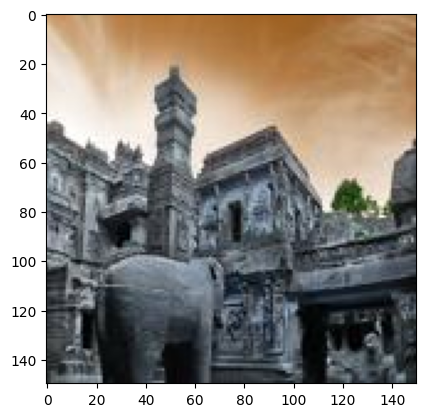

1/1 [==============================] - 1s 669ms/step


'Ellora Caves'

In [44]:
img = cv2.imread('/content/Indian-monuments/images/test/Ellora Caves/1.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [8]:
mobile_net = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


mobile_net.add(pretrained_model)
mobile_net.add(Flatten())
mobile_net.add(Dense(512, activation='relu'))
mobile_net.add(BatchNormalization())  # Batch Normalization layer
mobile_net.add(Dropout(0.5))

mobile_net.add(Dense(24, activation='softmax'))
pretrained_model.trainable=False

In [9]:
mobile_net.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
epochs=10
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10
115/115 [==============================] - 110s 868ms/step - loss: 1.2513 - accuracy: 0.6571 - val_loss: 4.3140 - val_accuracy: 0.4293
Epoch 2/10
115/115 [==============================] - 86s 749ms/step - loss: 0.4569 - accuracy: 0.8732 - val_loss: 3.7991 - val_accuracy: 0.5121
Epoch 3/10
115/115 [==============================] - 77s 671ms/step - loss: 0.2832 - accuracy: 0.9261 - val_loss: 3.8421 - val_accuracy: 0.5131
Epoch 4/10
115/115 [==============================] - 88s 771ms/step - loss: 0.1861 - accuracy: 0.9534 - val_loss: 3.8305 - val_accuracy: 0.5505
Epoch 5/10
115/115 [==============================] - 75s 652ms/step - loss: 0.1166 - accuracy: 0.9733 - val_loss: 4.0355 - val_accuracy: 0.5465
Epoch 6/10
115/115 [==============================] - 73s 633ms/step - loss: 0.0857 - accuracy: 0.9828 - val_loss: 4.3519 - val_accuracy: 0.5495
Epoch 7/10
115/115 [==============================] - 77s 672ms/step - loss: 0.0709 - accuracy: 0.9872 - val_loss: 4.6271 - val_a

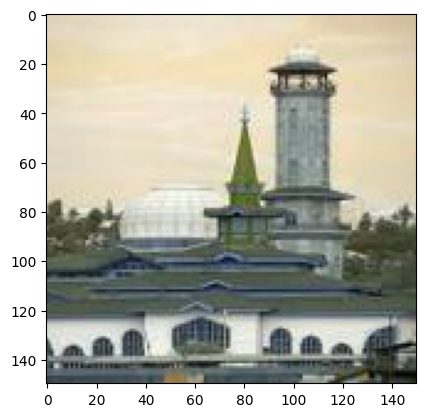

1/1 [==============================] - 2s 2s/step


'Charar-E- Sharif'

In [48]:
img = cv2.imread('/content/Indian-monuments/images/test/Charar-E- Sharif/51.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [12]:
import pickle
model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(mobile_net, file)

mobile_net.save('model.h5')

In [50]:
loaded_model = tf.keras.models.load_model("/content/model.h5")

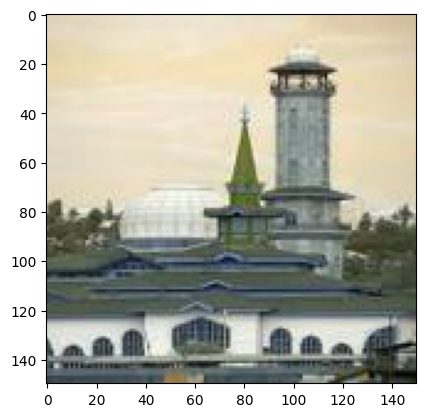

1/1 [==============================] - 1s 1s/step


'Charar-E- Sharif'

In [51]:
img = cv2.imread('/content/Indian-monuments/images/test/Charar-E- Sharif/51.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = loaded_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]